# Data Intensive Computing Final Project - Task4 - Oct. 2022
### Authors: Filippo Caliò - Dario Del Gaizo - Victor Lopo
### Team: LM10

In [0]:
import pyspark as pysp
import pandas as pd
import numpy as np
import org.apache.spark as sp
import pyspark.sql.functions as f

from matplotlib import pyplot as plt
from collections import Counter
from pyspark.ml.stat import Correlation
from pyspark.sql import DataFrame
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.feature import StringIndexer, PCA, VectorAssembler, UnivariateFeatureSelector
from pyspark.sql.functions import col,lit, monotonically_increasing_id
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql import functions as f


### Data Loading

In [0]:
df1 = spark.read.options(header='True', inferSchema='True', delimiter=',').csv('dbfs:/FileStore/tables/student_data.csv')
df2 = spark.read.options(header='True', inferSchema='True', delimiter=',').csv('dbfs:/FileStore/tables/student_por.csv')

### Data Preprocessing

In [0]:
diff1 = set(df1.columns).difference(df2.columns)
diff2 = set(df2.columns).difference(df1.columns)

# The total number of different rows is equal to the second dataset 
# This means that the two datasets are different (df1 is different from df2)
df1except = df1.exceptAll(df2)
total_number_diff_rows = df1except.count()
print(total_number_diff_rows)
print(df1.count())

# Same operation done in the other way (df2 is different from df1)
df2except = df2.exceptAll(df1)
total_number_diff_rows = df2except.count()
print(df2.count())
print(total_number_diff_rows)

Difference is:  0 0
395
395
649
649


In [0]:
df = df1.union(df2)
display(df)

school sex age address famsize Pstatus Medu Fedu Mjob Fjob reason guardian traveltime studytime failures schoolsup famsup paid activities nursery higher internet romantic famrel freetime goout Dalc Walc health absences G1 G2 G3 GP F 18 U GT3 A 4 4 at_home teacher course mother 2 2 0 yes no no no yes yes no no 4 3 4 1 1 3 6 5 6 6 GP F 17 U GT3 T 1 1 at_home other course father 1 2 0 no yes no no no yes yes no 5 3 3 1 1 3 4 5 5 6 GP F 15 U LE3 T 1 1 at_home other other mother 1 2 3 yes no yes no yes yes yes no 4 3 2 2 3 3 10 7 8 10 GP F 15 U GT3 T 4 2 health services home mother 1 3 0 no yes yes yes yes yes yes yes 3 2 2 1 1 5 2 15 14 15 GP F 16 U GT3 T 3 3 other other home father 1 2 0 no yes yes no yes yes no no 4 3 2 1 2 5 4 6 10 10 GP M 16 U LE3 T 4 3 services other reputation mother 1 2 0 no yes yes yes yes yes yes no 5 4 2 1 2 5 10 15 15 15 GP M 16 U LE3 T 2 2 other other home mother 1 2 0 no no no no yes yes yes no 4 4 4 1 1 3 0 12 12 11 GP F 17 U GT3 A 4 4 other teacher home mother 2 2 0 yes yes no no yes yes no no 4 1 4 1 1 1 6 6 5 6 GP M 15 U LE3 A 3 2 services other home mother 1 2 0 no yes yes no yes yes yes no 4 2 2 1 1 1 0 16 18 19 GP M 15 U GT3 T 3 4 other other home mother 1 2 0 no yes yes yes yes yes yes no 5 5 1 1 1 5 0 14 15 15 GP F 15 U GT3 T 4 4 teacher health reputation mother 1 2 0 no yes yes no yes yes yes no 3 3 3 1 2 2 0 10 8 9 GP F 15 U GT3 T 2 1 services other reputation father 3 3 0 no yes no yes yes yes yes no 5 2 2 1 1 4 4 10 12 12 GP M 15 U LE3 T 4 4 health services course father 1 1 0 no yes yes yes yes yes yes no 4 3 3 1 3 5 2 14 14 14 GP M 15 U GT3 T 4 3 teacher other course mother 2 2 0 no yes yes no yes yes yes no 5 4 3 1 2 3 2 10 10 11 GP M 15 U GT3 A 2 2 other other home other 1 3 0 no yes no no yes yes yes yes 4 5 2 1 1 3 0 14 16 16 GP F 16 U GT3 T 4 4 health other home mother 1 1 0 no yes no no yes yes yes no 4 4 4 1 2 2 4 14 14 14 GP F 16 U GT3 T 4 4 services services reputation mother 1 3 0 no yes yes yes yes yes yes no 3 2 3 1 2 2 6 13 14 14 GP F 16 U GT3 T 3 3 other other reputation mother 3 2 0 yes yes no yes yes yes no no 5 3 2 1 1 4 4 8 10 10 GP M 17 U GT3 T 3 2 services services course mother 1 1 3 no yes no yes yes yes yes no 5 5 5 2 4 5 16 6 5 5 GP M 16 U LE3 T 4 3 health other home father 1 1 0 no no yes yes yes yes yes no 3 1 3 1 3 5 4 8 10 10 GP M 15 U GT3 T 4 3 teacher other reputation mother 1 2 0 no no no no yes yes yes no 4 4 1 1 1 1 0 13 14 15 GP M 15 U GT3 T 4 4 health health other father 1 1 0 no yes yes no yes yes yes no 5 4 2 1 1 5 0 12 15 15 GP M 16 U LE3 T 4 2 teacher other course mother 1 2 0 no no no yes yes yes yes no 4 5 1 1 3 5 2 15 15 16 GP M 16 U LE3 T 2 2 other other reputation mother 2 2 0 no yes no yes yes yes yes no 5 4 4 2 4 5 0 13 13 12 GP F 15 R GT3 T 2 4 services health course mother 1 3 0 yes yes yes yes yes yes yes no 4 3 2 1 1 5 2 10 9 8 GP F 16 U GT3 T 2 2 services services home mother 1 1 2 no yes yes no no yes yes no 1 2 2 1 3 5 14 6 9 8 GP M 15 U GT3 T 2 2 other other home mother 1 1 0 no yes yes no yes yes yes no 4 2 2 1 2 5 2 12 12 11 GP M 15 U GT3 T 4 2 health services other mother 1 1 0 no no yes no yes yes yes no 2 2 4 2 4 1 4 15 16 15 GP M 16 U LE3 A 3 4 services other home mother 1 2 0 yes yes no yes yes yes yes no 5 3 3 1 1 5 4 11 11 11 GP M 16 U GT3 T 4 4 teacher teacher home mother 1 2 0 no yes yes yes yes yes yes yes 4 4 5 5 5 5 16 10 12 11 GP M 15 U GT3 T 4 4 health services home mother 1 2 0 no yes yes no no yes yes no 5 4 2 3 4 5 0 9 11 12 GP M 15 U GT3 T 4 4 services services reputation mother 2 2 0 no yes no yes yes yes yes no 4 3 1 1 1 5 0 17 16 17 GP M 15 R GT3 T 4 3 teacher at_home course mother 1 2 0 no yes no yes yes yes yes yes 4 5 2 1 1 5 0 17 16 16 GP M 15 U LE3 T 3 3 other other course mother 1 2 0 no no no yes no yes yes no 5 3 2 1 1 2 0 8 10 12 GP M 16 U GT3 T 3 2 other other home mother 1 1 0 no yes yes no no yes yes no 5 4 3 1 1 5 0 12 14 15 GP F 15 U GT3 T 2 3 other other other father 2 1 0 no yes no yes yes yes n

In [0]:
df.dtypes

Out[7]: [('school', 'string'),
 ('sex', 'string'),
 ('age', 'int'),
 ('address', 'string'),
 ('famsize', 'string'),
 ('Pstatus', 'string'),
 ('Medu', 'int'),
 ('Fedu', 'int'),
 ('Mjob', 'string'),
 ('Fjob', 'string'),
 ('reason', 'string'),
 ('guardian', 'string'),
 ('traveltime', 'int'),
 ('studytime', 'int'),
 ('failures', 'int'),
 ('schoolsup', 'string'),
 ('famsup', 'string'),
 ('paid', 'string'),
 ('activities', 'string'),
 ('nursery', 'string'),
 ('higher', 'string'),
 ('internet', 'string'),
 ('romantic', 'string'),
 ('famrel', 'int'),
 ('freetime', 'int'),
 ('goout', 'int'),
 ('Dalc', 'int'),
 ('Walc', 'int'),
 ('health', 'int'),
 ('absences', 'int'),
 ('G1', 'int'),
 ('G2', 'int'),
 ('G3', 'int')]

Out[5]: <AxesSubplot:>

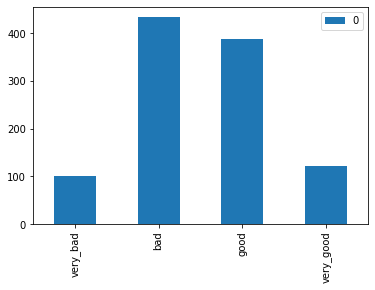

In [0]:
# The final grade (target) is going to be group in 4 classes for the multiclass classification task

# Very bad --> grades from 0 to 7
# Bad --> grades from 7 to 11
# Good --> grades from 11 to 15
# Very good --> grades from 15 to 20


df = df.withColumn('Grade1', f.when(f.col('G1') <= 7, "very_bad")
                        .when((f.col('G1') > 7) & (f.col('G1') <= 11), "bad")
                        .when((f.col('G1') > 11) & (f.col('G1') <= 15), "good")
                       .otherwise("very_good"))

df = df.withColumn('Grade2', f.when(f.col('G2') <= 7, "very_bad")
                        .when((f.col('G2') > 7) & (f.col('G2') <= 11), "bad")
                        .when((f.col('G2') > 11) & (f.col('G2') <= 15), "good")
                       .otherwise("very_good"))

df = df.withColumn('Grade3', f.when(f.col('G3') <= 7, "very_bad")
                        .when((f.col('G3') > 7) & (f.col('G3') <= 11), "bad")
                        .when((f.col('G3') > 11) & (f.col('G3') <= 15), "good")
                       .otherwise("very_good"))


# Checking if the four labels are balanced to have a Gaussian distribution

grades = df.select('Grade3').rdd.flatMap(lambda x: x).collect()
count = Counter(grades)
grades_df = pd.DataFrame.from_dict(count, orient='index')
grades_df.plot(kind='bar')


### Train-Test split

In [0]:
df = df.drop("G1").drop("G2").drop("G3")
input_cols = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", "Grade1", "Grade2", "Grade3"]

index_cols = ["school_Idx", "sex_Idx", "address_Idx", "famsize_Idx", "Pstatus_Idx", "Mjob_Idx", "Fjob_Idx", "reason_Idx", "guardian_Idx", "schoolsup_Idx", "famsup_Idx", "paid_Idx", "activities_Idx", "nursery_Idx", "higher_Idx", "internet_Idx", "romantic_Idx", "Grade1_Idx", "Grade2_Idx", "Grade3_Idx"]

indexer = StringIndexer(inputCols=input_cols, outputCols=index_cols)

df_indexed = indexer.fit(df).transform(df)
df_indexed = df_indexed.drop("school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", "Grade1", "Grade2", "Grade3")


/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
<command-4428537841257942>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
<command-4428537841257942>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


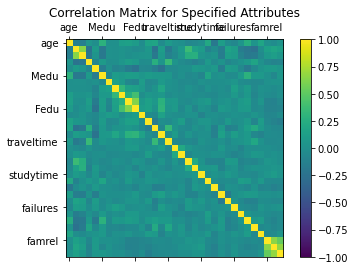

In [0]:
# convert to vector column first
vector_col = "corr_features"
assembler_corr = VectorAssembler(inputCols=df_indexed.columns, outputCol=vector_col)
df_vector = assembler_corr.transform(df_indexed).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

# The features with more correlation are Grade 1 and Grade 2
# Grade 1 and Grade 2 are grades of previous test in the course
# They don't have direct influence in the final grade (one final exam)

plot_corr_matrix(cor_np, df_indexed.columns, 234)

In [0]:
# 15 % of the data goes to the test set and 85 % to the train set

perc = 0.85
train_df, test_df = df_indexed.randomSplit([perc, 1-perc], seed=42)
display(train_df)
display(test_df)

age Medu Fedu traveltime studytime failures famrel freetime goout Dalc Walc health absences school_Idx sex_Idx address_Idx famsize_Idx Pstatus_Idx Mjob_Idx Fjob_Idx reason_Idx guardian_Idx schoolsup_Idx famsup_Idx paid_Idx activities_Idx nursery_Idx higher_Idx internet_Idx romantic_Idx Grade1_Idx Grade2_Idx Grade3_Idx 15 1 1 1 2 0 4 3 2 2 3 4 2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 15 1 1 1 2 0 4 4 2 1 2 5 0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15 1 1 1 2 2 3 3 4 2 4 5 2 0.0 0.0 1.0 0.0 0.0 0.0 0.0 2.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 2.0 3.0 15 1 1 1 2 3 4 3 2 2 3 3 10 0.0 0.0 0.0 1.0 0.0 2.0 0.0 3.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 15 1 1 2 4 1 3 1 2 1 1 1 2 0.0 0.0 1.0 0.0 0.0 2.0 0.0 1.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 15 1 1 3 1 0 4 3 3 1 2 4 0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 2.0 3.0 15 1 2 1 2 0 4 3 2 1 1 5 2 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 15 2 1 1 2 0 5 4 2 1 1 5 8 0.0 1.0 1.0 0.0 0.0 4.0 1.0 2.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 15 2 1 3 3 0 5 2 2 1 1 4 4 0.0 0.0 0.0 0.0 0.0 1.0 0.0 2.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 15 2 1 4 1 3 4 5 5 2 5 5 0 0.0 1.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15 2 2 1 1 0 4 2 2 1 2 5 2 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 15 2 2 1 1 0 4 3 1 1 1 2 8 0.0 0.0 1.0 0.0 0.0 2.0 0.0 2.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 15 2 2 1 1 0 5 4 1 1 1 1 0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15 2 2 1 3 0 4 5 2 1 1 3 0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 3.0 2.0 15 2 2 1 4 0 4 3 4 1 1 4 6 0.0 1.0 0.0 1.0 0.0 1.0 4.0 2.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 15 2 2 1 4 0 5 1 2 1 1 3 8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 15 2 2 1 4 0 5 5 4 1 2 5 6 0.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 3.0 1.0 1.0 15 2 2 2 2 0 4 1 3 1 3 4 2 0.0 0.0 1.0 1.0 0.0 4.0 1.0 2.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15 2 2 2 2 0 5 3 3 1 3 4 4 0.0 1.0 0.0 1.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 15 2 3 1 1 0 3 2 2 1 3 3 2 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 15 2 3 1 2 0 4 4 4 1 1 1 2 0.0 1.0 1.0 0.0 0.0 2.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 15 2 3 2 1 0 3 5 1 1 1 5 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 2.0 3.0 15 2 4 1 3 0 4 3 2 1 1 5 2 0.0 0.0 1.0 0.0 0.0 1.0 4.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15 3 1 2 4 0 4 4 2 2 3 3 12 0.0 0.0 1.0 1.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 3.0 3.0 2.0 15 3 2 1 2 0 4 2 2 1 1 1 0 0.0 1.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 3.0 3.0 2.0 15 3 2 1 2 0 4 4 4 1 1 5 10 0.0 0.0 0.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0 2.0 3.0 15 3 2 1 2 3 3 3 2 1 1 3 0 0.0 0.0 0.0 0.0 0.0 4.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 2.0 3.0 15 3 2 2 2 0 4 3 5 1 1 2 26 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0 2.0 3.0 15 3 2 2 2 2 4 4 4 1 4 3 6 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2.0 0.0 3.0 15 3 3 1 1 0 5 3 4 4 4 1 6 0.0 0.0 0.0 1.0 1.0 0.0 0.0 3.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 15 3 3 1 2 0 5 3 2 1 1 2 0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 15 3 3 1 4 0 4 3 3 1 1 4 10 0.0 0.0 0.0 0.0 1.0 0.0 4.0 2.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 15 3 4 1 1 0 3 4 3 1 2 4 6 0.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 15 3 4 1 1 0 5 5 5 3 2 5 0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 15 3 4 1 2 0 5 3 2 1 1 1 0 0.0 0.0 0.

age Medu Fedu traveltime studytime failures famrel freetime goout Dalc Walc health absences school_Idx sex_Idx address_Idx famsize_Idx Pstatus_Idx Mjob_Idx Fjob_Idx reason_Idx guardian_Idx schoolsup_Idx famsup_Idx paid_Idx activities_Idx nursery_Idx higher_Idx internet_Idx romantic_Idx Grade1_Idx Grade2_Idx Grade3_Idx 15 1 2 1 2 0 3 2 3 1 2 1 2 0.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 3.0 1.0 1.0 15 1 2 1 2 0 4 3 2 1 1 5 2 0.0 1.0 0.0 1.0 0.0 0.0 3.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15 2 3 1 3 0 5 3 2 1 2 5 4 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 15 3 3 2 3 2 4 2 1 2 3 3 8 0.0 0.0 1.0 0.0 0.0 1.0 1.0 2.0 2.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 15 4 2 1 1 0 3 5 2 1 1 3 10 0.0 1.0 0.0 1.0 0.0 3.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 3.0 2.0 15 4 2 1 2 0 4 3 3 1 1 5 2 0.0 0.0 0.0 1.0 0.0 4.0 0.0 3.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 15 4 2 1 3 0 3 2 2 1 1 5 2 0.0 0.0 0.0 0.0 0.0 4.0 1.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 15 4 2 1 4 0 3 3 3 1 1 3 0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15 4 3 1 2 0 4 3 3 2 3 5 6 0.0 1.0 0.0 0.0 0.0 3.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15 4 3 2 4 0 2 2 2 1 1 3 0 0.0 1.0 0.0 0.0 0.0 3.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 3.0 15 4 4 1 2 0 3 2 2 1 1 5 4 0.0 1.0 0.0 0.0 0.0 3.0 4.0 2.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 15 4 4 2 1 0 4 3 2 1 1 5 0 0.0 0.0 0.0 0.0 0.0 3.0 2.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 3.0 3.0 1.0 16 2 2 1 1 2 1 2 2 1 3 5 14 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 2.0 0.0 0.0 16 2 2 3 1 0 4 2 2 1 2 3 2 0.0 1.0 1.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 3.0 1.0 1.0 16 2 2 3 2 0 4 3 3 2 3 4 2 0.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 16 3 2 1 2 0 1 2 2 1 2 1 14 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 16 4 2 1 2 0 4 2 3 1 1 3 0 0.0 0.0 0.0 0.0 0.0 4.0 1.0 1.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 2.0 16 4 3 1 2 0 4 3 5 1 5 2 2 0.0 0.0 0.0 0.0 0.0 4.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 3.0 3.0 2.0 16 4 3 1 4 0 4 2 2 1 1 2 4 0.0 1.0 0.0 0.0 0.0 4.0 1.0 2.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 3.0 3.0 2.0 16 4 4 1 1 0 3 4 4 1 4 5 18 0.0 1.0 0.0 0.0 0.0 4.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 16 4 4 1 3 0 5 3 2 1 1 5 0 0.0 0.0 0.0 0.0 0.0 3.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 17 1 1 1 2 0 5 3 3 1 1 3 0 0.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 17 2 1 1 1 0 4 4 2 2 4 5 0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 17 2 2 1 3 0 4 3 3 1 1 4 4 0.0 0.0 0.0 0.0 0.0 2.0 3.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 17 2 3 1 2 0 5 3 3 1 3 3 2 0.0 1.0 0.0 1.0 0.0 1.0 1.0 2.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 17 3 2 1 2 0 4 3 3 2 3 2 4 0.0 0.0 1.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 17 4 2 1 4 0 4 2 3 1 1 4 6 0.0 0.0 0.0 1.0 0.0 3.0 1.0 2.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 17 4 3 1 2 0 5 2 2 1 2 5 23 0.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 17 4 3 2 2 0 2 5 5 1 4 5 14 0.0 1.0 0.0 1.0 0.0 4.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 17 4 3 2 2 0 4 5 5 1 3 2 4 1.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 18 1 1 2 2 1 1 1 1 1 1 5 0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 1.0 0.0 2.0 2.0 3.0 18 1 1 2 4 0 5 2 2 1 1 3 1 0.0 0.0 1.0 1.0 0.0 2.0 0.0 2.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 18 1 1 3 1 3 5 2 5 1 5 4 6 0.0 0.0 1.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 18 1 3 2 2 0 3 3 4 2 4 3 4 1.0 1.0 1.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 18 2 2 1 2 1 5 5 4 3 5 2 0 0.0 1.0 0

### Cross-validation to search the optimal number of features

In [0]:
train_df_labels = train_df.select("Grade3_Idx")
train_df_features = train_df.drop("Grade3_Idx")

assembler = VectorAssembler(inputCols=train_df_features.columns, outputCol="features")
train_df_features_top_study = assembler.transform(train_df_features)

In [0]:
# To train the models is neccessary that the train dataset is assembled

train_df_features_assembler = train_df_features_top_study.select("features")
train_df_features_assembler = train_df_features_assembler.withColumn("id",monotonically_increasing_id() )
train_df_labels = train_df_labels.withColumn( "id", monotonically_increasing_id() )
train_df_merged = train_df_features_assembler.join(train_df_labels,train_df_features_assembler.id == train_df_labels.id, how='inner')
train_df_merged = train_df_merged.drop("id").drop("id")
train_df_merged = train_df_merged.withColumnRenamed("Grade3_Idx", "label")

In [0]:
list_features = range(5, 16, 1)
name_list_dict = {}
selector = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures", labelCol="label", selectionMode="numTopFeatures")

for num_features in list_features:
    selector.setFeatureType("categorical").setLabelType("categorical").setSelectionThreshold(num_features)
    result = selector.fit(train_df_merged)
    name_list_dict["features_" + str(num_features)] = np.array(train_df.columns)[result.selectedFeatures] #dictionary {features_num -> list of features}
    
display(name_list_dict)

{'features_5': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu'],
       dtype='<U14'),
 'features_6': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx'], dtype='<U14'),
 'features_7': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu'], dtype='<U14'),
 'features_8': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu', 'studytime'], dtype='<U14'),
 'features_9': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu', 'studytime', 'Dalc'], dtype='<U14'),
 'features_10': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu', 'studytime', 'Dalc', 'goout'], dtype='<U14'),
 'features_11': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu', 'studytime', 'Dalc', 'goout', 'address_Idx'],
       dtype='<U14'),
 'features_12':

In [0]:
keys = name_list_dict.keys()
assembled_list = []
i = 0

for k in keys:
    out = "features_" + str(5+i)
    assembler = VectorAssembler(inputCols=name_list_dict[k], outputCol=out)
    transformed_df = assembler.transform(train_df_features)
    assembled_list.append(transformed_df.select(out))
    i = i + 1


In [0]:
final_dfs =  []
train_df_labels = train_df_labels.withColumn("id", monotonically_increasing_id())

for i in range(len(assembled_list)):
    temp = assembled_list[i]
    temp = temp.withColumn("id", monotonically_increasing_id())
    final_dfs.append(temp.join(train_df_labels, temp.id == train_df_labels.id, how='inner'))
    final_dfs[i] = final_dfs[i].drop("id").drop("id")
    
for a in final_dfs:
    display(a)

features_5 Grade3_Idx Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 0.0, 2.0, 0.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 2.0, 0.0, 0.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(1.0, 2.0, 0.0, 0.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(2.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(0, 4), values -> List(3.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 3.0, 0.0, 2.0)) 2.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(1, 4), values -> List(2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 1.0, 0.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(2.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 3.0, 0.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 3.0, 0.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 2.0, 0.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 2.0, 2.0, 0.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 2.0, 0.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 2.0, 0.0, 0.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(1.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(3.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(3.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(1, 4), values -> List(2.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 3.0, 0.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 1.0, 2.0, 0.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(2.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(4.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 3.0, 0.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(0, 4), values -> List(1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 3.0, 0.0, 4.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> Li

features_6 Grade3_Idx Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(1.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1, 4), values -> List(2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(2, 4), values -> List(1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(2, 4), values -> List(2.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0)) 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(2, 4), values -> List(1.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(3.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(3.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1, 4), values -> List(2.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(2.0, 1.0, 2.0, 0.0, 3.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 0.0, 2.0, 0.0, 3.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(4.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 3.0, 0.0, 4.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 4.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 4.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(1.0, 0.0, 0.0, 0.0, 4

features_7 Grade3_Idx Map(vectorType -> sparse, length -> 7, indices -> List(4, 6), values -> List(1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 6), values -> List(1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(1.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 7, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(1, 4, 6), values -> List(2.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 4.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(2, 4, 6), values -> List(1.0, 2.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 2.0, 3.0)) 0.0 Map(vectorType -> sparse, length -> 7, indices -> List(2, 4, 6), values -> List(2.0, 2.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 7, indices -> List(2, 4, 6), values -> List(1.0, 3.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 6), values -> List(3.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 6), values -> List(3.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(1, 4, 6), values -> List(2.0, 3.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 4.0)) 2.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(2.0, 1.0, 2.0, 0.0, 3.0, 1.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.0, 2.0, 0.0, 3.0, 2.0, 4.0)) 3.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5), values -> List(4.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 3.0, 0.0, 4.0, 4.0, 2.0)) 1.0 

features_8 Grade3_Idx Map(vectorType -> sparse, length -> 8, indices -> List(4, 6, 7), values -> List(1.0, 1.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 6, 7), values -> List(1.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 8, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 8, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1, 4, 6, 7), values -> List(2.0, 2.0, 2.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 4.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(2, 4, 6, 7), values -> List(1.0, 2.0, 3.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 2.0, 3.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(2, 4, 6, 7), values -> List(2.0, 2.0, 3.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 1.0, 4.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0)) 2.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 8, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 8, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 8, indices -> List(2, 4, 6, 7), values -> List(1.0, 3.0, 3.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 6, 7), values -> List(3.0, 3.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 6, 7), values -> List(3.0, 3.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1, 4, 6, 7), values -> List(2.0, 3.0, 4.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 4.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(2.0, 1.0, 2.0, 0.0, 3.0, 1.0, 4.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 8, 

features_9 Grade3_Idx Map(vectorType -> sparse, length -> 9, indices -> List(4, 6, 7, 8), values -> List(1.0, 1.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 9, indices -> List(4, 6, 7, 8), values -> List(1.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 3.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 3.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 3.0, 1.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 9, indices -> List(4, 6, 7, 8), values -> List(3.0, 3.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 9, indices -> List(4, 6, 7, 8), values -> List(3.0, 3.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 4.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 4.0, 2.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 2.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values

features_10 Grade3_Idx Map(vectorType -> sparse, length -> 10, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 10, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 5.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 3.0, 1.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 5.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 3.0, 1.0, 4.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 10, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 10, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 4.0, 1.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 1.0, 3.0, 5.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 4.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 4.0, 2.0, 1.0, 4.0)) 2.0 Map(vectorType -> den

features_11 Grade3_Idx Map(vectorType -> sparse, length -> 11, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 11, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 11, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 0.0)) 3.0 Map(vectorType -> sparse, length -> 11, indices -> List(4, 5, 6, 7, 8, 9), values -> List(1.0, 2.0, 2.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 11, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 5.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 11, indices -> List(4, 5, 6, 7, 8, 9), values -> List(2.0, 1.0, 2.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 3.0, 1.0, 2.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0)) 1.0 Map(vectorType -> sparse, length -> 11, indices -> List(1, 4, 6, 7, 8, 9), values -> List(2.0, 2.0, 2.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 0.0)) 1.0 Map(vectorType -> sparse, length -> 11, indices -> List(2, 4, 6, 7, 8, 9), values -> List(1.0, 2.0, 3.0, 1.0, 1.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0, 4.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 11, indices -> List(2, 4, 6, 7, 8, 9), values -> List(2.0, 2.0, 3.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0, 2.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 4.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 11, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0, 2.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 5.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 11, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0, 4.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 11, indices -> List(2, 4, 6, 7, 8, 9), values -> List(1.0, 3.0, 3.0, 1.0, 4.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 11, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 11, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 4.0, 1.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 3.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 11, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 1.0, 3.0, 5.0, 0.0)) 1.0 Map(vectorType -> spars

features_12 Grade3_Idx Map(vectorType -> sparse, length -> 12, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 12, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0, 1.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 12, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0, 1.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0)) 3.0 Map(vectorType -> sparse, length -> 12, indices -> List(4, 5, 6, 7, 8, 9), values -> List(1.0, 2.0, 2.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0, 0.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 12, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 5.0, 0.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0)) 1.0 Map(vectorType -> sparse, length -> 12, indices -> List(4, 5, 6, 7, 8, 9), values -> List(2.0, 1.0, 2.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 3.0, 1.0, 2.0, 0.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0, 0.0)) 1.0 Map(vectorType -> sparse, length -> 12, indices -> List(1, 4, 6, 7, 8, 9), values -> List(2.0, 2.0, 2.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0, 3.0, 1.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 0.0, 0.0)) 1.0 Map(vectorType -> sparse, length -> 12, indices -> List(2, 4, 6, 7, 8, 9), values -> List(1.0, 2.0, 3.0, 1.0, 1.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0, 4.0, 1.0, 0.0)) 0.0 Map(vectorType -> sparse, length -> 12, indices -> List(2, 4, 6, 7, 8, 9), values -> List(2.0, 2.0, 3.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 2.0, 1.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0, 2.0, 1.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 4.0, 0.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 12, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 5.0, 0.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 12, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0)) 3.0 Map(vectorType -> sparse, length -> 12, indices -> List(2, 4, 6, 7, 8, 9), values -> List(1.0, 3.0, 3.0, 1.0, 4.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 12, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 12, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 4.0, 1.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 12, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 3.0, 0.0, 0.0)) 1.0 Map(vectorType -> dens

features_13 Grade3_Idx Map(vectorType -> sparse, length -> 13, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 13, indices -> List(4, 6, 7, 8, 9, 12), values -> List(1.0, 1.0, 2.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 13, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0, 1.0, 0.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 13, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 13, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0, 1.0, 0.0, 0.0)) 0.0 Map(vectorType -> sparse, length -> 13, indices -> List(2, 4, 5, 6, 7, 8, 9), values -> List(2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 13, indices -> List(4, 5, 6, 7, 8, 9), values -> List(1.0, 2.0, 2.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 13, indices -> List(2, 4, 5, 6, 7, 8, 9), values -> List(1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 4, 5, 6, 7, 8, 9), values -> List(3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 5.0)) 0.0 Map(vectorType -> sparse, length -> 13, indices -> List(1, 2, 4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0)) 1.0 Map(vectorType -> sparse, length -> 13, indices -> List(4, 5, 6, 7, 8, 9, 12), values -> List(2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 13, indices -> List(1, 2, 4, 6, 7, 8, 9), values -> List(1.0, 3.0, 2.0, 2.0, 3.0, 1.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0, 0.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 13, indices -> List(1, 4, 6, 7, 8, 9), values -> List(2.0, 2.0, 2.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0, 0.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0, 3.0, 1.0, 0.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 0.0, 0.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 13, indices -> List(2, 4, 6, 7, 8, 9, 12), values -> List(1.0, 2.0, 3.0, 1.0, 1.0, 2.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0, 4.0, 1.0, 0.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 13, indices -> List(2, 4, 6, 7, 8, 9), values -> List(2.0, 2.0, 3.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 2.0, 1.0, 0.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 13, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 13, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 5.0, 0.0, 0.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 13, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0, 0.0)) 3.0 Map(vectorType -> sparse, length -> 13, indices -> List(2, 4, 6, 7, 8, 9), values -> List(1.0, 3.0, 3.0, 1.0, 4.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 13, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 13, indices -> List(4, 6, 7, 8, 9, 12), 

features_14 Grade3_Idx Map(vectorType -> sparse, length -> 14, indices -> List(4, 6, 7, 8, 9, 13), values -> List(1.0, 1.0, 2.0, 2.0, 2.0, 3.0)) 0.0 Map(vectorType -> sparse, length -> 14, indices -> List(4, 6, 7, 8, 9, 12, 13), values -> List(1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 14, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0, 1.0, 0.0, 0.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 14, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 14, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 14, indices -> List(2, 4, 5, 6, 7, 8, 9, 13), values -> List(2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 14, indices -> List(4, 5, 6, 7, 8, 9, 13), values -> List(1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 14, indices -> List(2, 4, 5, 6, 7, 8, 9, 13), values -> List(1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 14, indices -> List(0, 4, 5, 6, 7, 8, 9, 13), values -> List(3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 5.0, 5.0)) 0.0 Map(vectorType -> sparse, length -> 14, indices -> List(1, 2, 4, 6, 7, 8, 9, 13), values -> List(1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 14, indices -> List(4, 5, 6, 7, 8, 9, 12, 13), values -> List(2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 14, indices -> List(1, 2, 4, 6, 7, 8, 9, 13), values -> List(1.0, 3.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0, 0.0, 4.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 14, indices -> List(1, 4, 6, 7, 8, 9, 13), values -> List(2.0, 2.0, 2.0, 4.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0, 0.0, 1.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0, 3.0, 1.0, 0.0, 1.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 0.0, 0.0, 1.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 14, indices -> List(2, 4, 6, 7, 8, 9, 12, 13), values -> List(1.0, 2.0, 3.0, 1.0, 1.0, 2.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0, 4.0, 1.0, 0.0, 1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 14, indices -> List(2, 4, 6, 7, 8, 9, 13), values -> List(2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 2.0, 1.0, 0.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 14, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 14, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 5.0, 0.0, 0.0, 0.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 14, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0, 0.0, 4.0)) 3.0 Map(vectorType -> sparse, length -> 14, indices -> List(2, 4, 6, 7, 8, 9, 13), values -> List(1.0, 3.0, 3.0, 1.0, 4.0, 4.0, 4

features_15 Grade3_Idx Map(vectorType -> sparse, length -> 15, indices -> List(4, 6, 7, 8, 9, 13), values -> List(1.0, 1.0, 2.0, 2.0, 2.0, 3.0)) 0.0 Map(vectorType -> sparse, length -> 15, indices -> List(4, 6, 7, 8, 9, 12, 13), values -> List(1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 15, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0, 1.0, 0.0, 0.0, 4.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 15, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 15, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 15, indices -> List(2, 4, 5, 6, 7, 8, 9, 13), values -> List(2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 15, indices -> List(4, 5, 6, 7, 8, 9, 13), values -> List(1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0)) 0.0 Map(vectorType -> sparse, length -> 15, indices -> List(2, 4, 5, 6, 7, 8, 9, 13), values -> List(1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 15, indices -> List(0, 4, 5, 6, 7, 8, 9, 13), values -> List(3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 5.0, 5.0)) 0.0 Map(vectorType -> sparse, length -> 15, indices -> List(1, 2, 4, 6, 7, 8, 9, 13), values -> List(1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 15, indices -> List(1, 2, 4, 6, 7, 8, 9, 13), values -> List(1.0, 3.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0, 0.0, 4.0, 1.0, 0.0)) 1.0 Map(vectorType -> sparse, length -> 15, indices -> List(1, 4, 6, 7, 8, 9, 13, 14), values -> List(2.0, 2.0, 2.0, 4.0, 1.0, 2.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 0.0, 0.0, 1.0, 2.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0, 3.0, 1.0, 0.0, 1.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 0.0, 0.0, 1.0, 3.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 3.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0, 4.0, 1.0, 0.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 15, indices -> List(2, 4, 6, 7, 8, 9, 13), values -> List(2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 2.0, 1.0, 0.0, 4.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 3.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 15, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 15, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 5.0, 0.0, 0.0, 0.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 15, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0, 0.0, 4.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 15, indices -

In [0]:
# Store the accuracies of all the models obtained in the cross validation in a list

accuracies = {}
i = 0

reduce_final_dfs = final_dfs[:6]

for a in reduce_final_dfs:
    display(a)

features_5 Grade3_Idx Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 0.0, 2.0, 0.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 2.0, 0.0, 0.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(1.0, 2.0, 0.0, 0.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(2.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(0, 4), values -> List(3.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 3.0, 0.0, 2.0)) 2.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(1, 4), values -> List(2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 1.0, 0.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(2.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(2.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 3.0, 0.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 3.0, 0.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 2.0, 0.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(3.0, 2.0, 2.0, 0.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 2.0, 2.0, 0.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 2.0, 0.0, 0.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(1.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(3.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(3.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(1, 4), values -> List(2.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 3.0, 0.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(2.0, 1.0, 2.0, 0.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(2, 4), values -> List(2.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 5, indices -> List(4), values -> List(4.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 3.0, 0.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 1.0, 1.0, 0.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 5, indices -> List(0, 4), values -> List(1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 5, values -> List(0.0, 3.0, 3.0, 0.0, 4.0)) 2.0 Map(vectorType -> dense, length -> 5, values -> Li

features_6 Grade3_Idx Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(1.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1, 4), values -> List(2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(2, 4), values -> List(1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 6, indices -> List(2, 4), values -> List(2.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0)) 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(2, 4), values -> List(1.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(3.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(3.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 6, indices -> List(1, 4), values -> List(2.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(2.0, 1.0, 2.0, 0.0, 3.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 0.0, 2.0, 0.0, 3.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 6, indices -> List(4, 5), values -> List(4.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 3.0, 0.0, 4.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 4.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(0.0, 1.0, 1.0, 0.0, 4.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 6, values -> List(1.0, 0.0, 0.0, 0.0, 4

features_7 Grade3_Idx Map(vectorType -> sparse, length -> 7, indices -> List(4, 6), values -> List(1.0, 1.0)) 0.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 6), values -> List(1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(1.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 7, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(1, 4, 6), values -> List(2.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 4.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(2, 4, 6), values -> List(1.0, 2.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 2.0, 3.0)) 0.0 Map(vectorType -> sparse, length -> 7, indices -> List(2, 4, 6), values -> List(2.0, 2.0, 3.0)) 3.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5, 6), values -> List(2.0, 1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 7, indices -> List(2, 4, 6), values -> List(1.0, 3.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 6), values -> List(3.0, 3.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 6), values -> List(3.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 7, indices -> List(1, 4, 6), values -> List(2.0, 3.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 4.0)) 2.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(2.0, 1.0, 2.0, 0.0, 3.0, 1.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 0.0, 2.0, 0.0, 3.0, 2.0, 4.0)) 3.0 Map(vectorType -> sparse, length -> 7, indices -> List(4, 5), values -> List(4.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 7, values -> List(0.0, 1.0, 3.0, 0.0, 4.0, 4.0, 2.0)) 1.0 

features_8 Grade3_Idx Map(vectorType -> sparse, length -> 8, indices -> List(4, 6, 7), values -> List(1.0, 1.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 6, 7), values -> List(1.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 8, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 8, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 3.0)) 2.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1, 4, 6, 7), values -> List(2.0, 2.0, 2.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 4.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(2, 4, 6, 7), values -> List(1.0, 2.0, 3.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 2.0, 3.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 8, indices -> List(2, 4, 6, 7), values -> List(2.0, 2.0, 3.0, 1.0)) 3.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 5, 6, 7), values -> List(2.0, 1.0, 4.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0)) 2.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 8, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 8, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0)) 3.0 Map(vectorType -> sparse, length -> 8, indices -> List(2, 4, 6, 7), values -> List(1.0, 3.0, 3.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 6, 7), values -> List(3.0, 3.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(4, 6, 7), values -> List(3.0, 3.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 8, indices -> List(1, 4, 6, 7), values -> List(2.0, 3.0, 4.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 4.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 8, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 8, values -> List(2.0, 1.0, 2.0, 0.0, 3.0, 1.0, 4.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 8, 

features_9 Grade3_Idx Map(vectorType -> sparse, length -> 9, indices -> List(4, 6, 7, 8), values -> List(1.0, 1.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 9, indices -> List(4, 6, 7, 8), values -> List(1.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 3.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 3.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 3.0, 1.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 9, indices -> List(4, 6, 7, 8), values -> List(3.0, 3.0, 2.0, 1.0)) 1.0 Map(vectorType -> sparse, length -> 9, indices -> List(4, 6, 7, 8), values -> List(3.0, 3.0, 4.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 4.0, 2.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 4.0, 2.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 2.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 9, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 3.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 9, values

features_10 Grade3_Idx Map(vectorType -> sparse, length -> 10, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> sparse, length -> 10, indices -> List(4, 6, 7, 8, 9), values -> List(1.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 5.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 3.0, 1.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 4.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 2.0, 1.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0, 2.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 2.0, 1.0, 4.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0, 1.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 4.0, 2.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0)) 2.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(3.0, 2.0, 2.0, 0.0, 3.0, 4.0, 2.0, 2.0, 1.0, 2.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 5.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 1.0, 4.0)) 3.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 3.0, 1.0, 4.0, 4.0)) 1.0 Map(vectorType -> sparse, length -> 10, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 2.0, 1.0, 2.0)) 1.0 Map(vectorType -> sparse, length -> 10, indices -> List(4, 6, 7, 8, 9), values -> List(3.0, 3.0, 4.0, 1.0, 3.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 1.0, 3.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 4.0, 1.0, 3.0, 5.0)) 1.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 4.0, 2.0, 1.0, 2.0)) 0.0 Map(vectorType -> dense, length -> 10, values -> List(0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 4.0, 2.0, 1.0, 4.0)) 2.0 Map(vectorType -> den

In [0]:
# For loop to cross-validate the models with different features

models = []
for df in reduce_final_dfs:
    out = "features_" + str(5+i)
    df = df.withColumnRenamed(out, "features").withColumnRenamed("Grade3_Idx", "label")
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
    evaluator = MulticlassClassificationEvaluator()  

    pipeline = Pipeline(stages=[rf])
    paramGrid = (ParamGridBuilder().addGrid(rf.numTrees, [64, 128]).addGrid(rf.maxDepth, [0, 3]).build())

    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=10)

    model = crossval.fit(df)
    models.append(model)

    avgMetricsGrid = model.avgMetrics
    model_name = "model_" + str(5+i)
    accuracies[model_name] = max(avgMetricsGrid)
    i = i + 1
    
    

In [0]:
# Print the accuracies of each model

print(accuracies)

{'model_5': 0.8577192723180639, 'model_6': 0.8586912017076074, 'model_7': 0.8470210463093004, 'model_8': 0.8418410940604029, 'model_9': 0.8181003395331349, 'model_10': 0.8425706459569655}


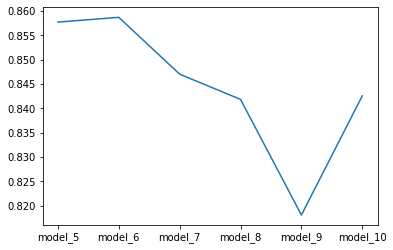

In [0]:
lists = accuracies.items() 

# unpack a list of pairs into two tuples

x, y = zip(*lists) 

plt.plot(x, y)
plt.show()

In [0]:
# Assemble the test dataset to be able to make predictions

input_cols = ["failures", "Grade1_Idx", "Grade2_Idx", "higher_Idx", "Medu", "Mjob_Idx"]
test_df_6 = test_df.select("failures", "Grade1_Idx", "Grade2_Idx", "higher_Idx", "Medu", "Mjob_Idx", "Grade3_Idx")
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
transformed_df_6 = assembler.transform(test_df_6)
transformed_df_6 = transformed_df_6.withColumnRenamed("Grade3_Idx", "label")
test_df_assembled_6 = transformed_df_6.select("features", "label")



In [0]:
# Cross-validation of the model of 6 features

to_train = final_dfs[1].withColumnRenamed("features_6", "features").withColumnRenamed("Grade3_Idx", "label")
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
evaluator = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")

# Pipeline and grid to find the optimal parameters of the random forest

pipeline = Pipeline(stages=[rf])
paramGrid = (ParamGridBuilder().addGrid(rf.numTrees, [100, 300]).addGrid(rf.maxDepth, [0, 4]).build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=10)

model_6 = crossval.fit(to_train)


avgMetricsGrid = model_6.avgMetrics
accuracy_6 = max(avgMetricsGrid)

In [0]:
# Accuracy of the cross-validation 


accuracy_6

Out[23]: 0.8566779396659564

In [0]:
predictions_6 = model_6.transform(test_df_assembled_6)

evaluator_6 = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")

accuracy_6 = evaluator_6.evaluate(predictions_6)

# Accuracy over the test set (slightly lower than in the cross validation)

print(accuracy_6)

0.8376623376623377


In [0]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
evaluator = MulticlassClassificationEvaluator()  

# Pipeline to search the most optimal parameters for the random tree

pipeline = Pipeline(stages=[rf])
paramGrid = (ParamGridBuilder().addGrid(rf.numTrees, [100, 200]).addGrid(rf.maxDepth, [0, 3]).build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=10)

# Train the model with 32 features

model = crossval.fit(train_df_merged)

In [0]:
in_cols = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel","freetime", "goout", "Dalc", "Walc", "health", "absences", "school_Idx", "sex_Idx", "address_Idx", "famsize_Idx", "Pstatus_Idx", "Mjob_Idx", "Fjob_Idx", "reason_Idx", "guardian_Idx", "schoolsup_Idx", "famsup_Idx", "paid_Idx", "activities_Idx", "nursery_Idx", "higher_Idx", "internet_Idx", "romantic_Idx", "Grade1_Idx", "Grade2_Idx"]

assembler = VectorAssembler(inputCols=in_cols, outputCol="features")
full_prediction_test_df = assembler.transform(test_df)
full_prediction_test_df = full_prediction_test_df.withColumnRenamed("Grade3_Idx", "label")
full_prediction_test_df = full_prediction_test_df.select("features", "label")

In [0]:
predictions = model.transform(full_prediction_test_df)

evaluator = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")

accuracy = evaluator.evaluate(predictions)

# This is the accuracy of the 32 feature model over the test set

print(accuracy)

0.7402597402597403


In [0]:
train_df_PCA = train_df.withColumnRenamed("Grade3_Idx", "label")
test_df_PCA = test_df.withColumnRenamed("Grade3_Idx", "label")
assembler_PCA = VectorAssembler( inputCols=train_df_PCA.columns[:-1], outputCol="features")

pca = PCA(k=6, inputCol="features", outputCol="pcaFeature")

model_PCA_RF = RandomForestClassifier(labelCol="label", featuresCol="pcaFeature", seed=42, numTrees = 300, maxDepth= 4)
pipeline_PCA_LR = Pipeline (stages=[assembler_PCA,pca, model_PCA_RF])
model_PCA_RF = pipeline_PCA_LR.fit(train_df_PCA)
predictions_PCA_RF = model_PCA_RF.transform(test_df_PCA)
evaluator_PCA_RF = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")
accuracy_PCA_RF = evaluator_PCA_RF.evaluate(predictions_PCA_RF)
print(accuracy_PCA_RF)

# Not optimal approach (low accuracy compared to previous models)

0.6038961038961039


In [0]:
# Why is the accuracy so low? Let's see the variance explained by each component of the pca

assembler_variance = VectorAssembler(inputCols=train_df_PCA.columns, outputCol="features")
train_df_PCA_variance = assembler_variance.transform(train_df_PCA)
model_variance = pca.fit(train_df_PCA_variance)
dense_vector = model_variance.explainedVariance

Out[18]: <BarContainer object of 6 artists>

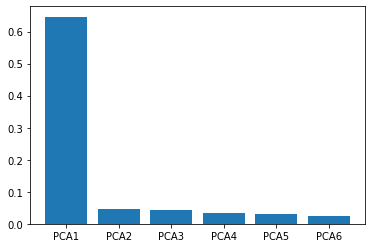

In [0]:
import matplotlib.pyplot as plt

xaxis = ["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6" ]
plt.bar(xaxis, dense_vector)

# Only the first component achieves to get a high variance (the rest components are really low)
# 64% of variance is really low to perform the prediction task correctly